### Imports, paths, output folder

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== EDIT THESE PATHS FOR YOUR MAC ====
DOCS = Path("/Users/rahellegesse/Documents/rahel_ds_projects/Data")
RAW_DEMAND_CSV   = DOCS / "totaldemand_nsw.csv"
RAW_TEMP_CSV     = DOCS / "temperature_nsw.csv"
RAW_FORECAST_CSV = DOCS / "forecastdemand_nsw.csv"   # set to a real file or leave as non-existent

OUTDIR = DOCS / "nsw_clean_outputs"
OUTDIR.mkdir(parents=True, exist_ok=True)

AUS_TZ = "Australia/Sydney"
print("Output folder:", OUTDIR)


Output folder: /Users/rahellegesse/Documents/rahel_ds_projects/Data/nsw_clean_outputs


### Load & clean ACTUAL demand (totaldemand_nsw)

In [2]:
# Read raw demand
demand_raw = pd.read_csv(RAW_DEMAND_CSV)
print("Raw demand shape:", demand_raw.shape)
display(demand_raw.head())

# Map columns (case-insensitive)
cmap = {c.lower(): c for c in demand_raw.columns}
tcol = cmap.get("datetime", "DATETIME")
ycol = cmap.get("totaldemand", "TOTALDEMAND")

# Parse to AU local, then drop tzinfo (naive local)
dt = pd.to_datetime(demand_raw[tcol], errors="coerce", dayfirst=True)
dt = dt.dt.tz_localize(AUS_TZ, nonexistent="shift_forward", ambiguous="NaT").dt.tz_localize(None)

demand = demand_raw.copy()
demand["datetime"] = dt
demand["demand_mw"] = pd.to_numeric(demand_raw[ycol], errors="coerce")

# NSW1 only (if present)
if "REGIONID" in demand.columns:
    demand = demand[demand["REGIONID"].astype(str).str.upper().eq("NSW1")]

# Keep, sort, deduplicate
demand = demand[["datetime", "demand_mw"]].dropna().sort_values("datetime")
demand = demand.drop_duplicates(subset=["datetime"], keep="last")

# Enforce continuous 30-min grid (no filling of target)
start, end = demand["datetime"].min(), demand["datetime"].max()
grid = pd.date_range(start=start, end=end, freq="30min")
demand = demand.set_index("datetime").reindex(grid)
demand.index.name = "datetime"
demand = demand.reset_index()

print("Cleaned demand shape:", demand.shape)
print("Demand date range:", demand["datetime"].min(), "→", demand["datetime"].max())
display(demand.head())


Raw demand shape: (196513, 3)


,DATETIME,TOTALDEMAND,REGIONID
0,1/1/2010 0:00,8038.00,NSW1
1,1/1/2010 0:30,7809.31,NSW1
2,1/1/2010 1:00,7483.69,NSW1
3,1/1/2010 1:30,7117.23,NSW1
4,1/1/2010 2:00,6812.03,NSW1


Cleaned demand shape: (196513, 2)
Demand date range: 2010-01-01 00:00:00 → 2021-03-18 00:00:00


,datetime,demand_mw
0,2010-01-01 00:00:00,8038.00
1,2010-01-01 00:30:00,7809.31
2,2010-01-01 01:00:00,7483.69
3,2010-01-01 01:30:00,7117.23
4,2010-01-01 02:00:00,6812.03


### Load & clean TEMPERATURE (temperature_nsw)

In [3]:
temp_raw = pd.read_csv(RAW_TEMP_CSV)
print("Raw temperature shape:", temp_raw.shape)
display(temp_raw.head())

cmap = {c.lower(): c for c in temp_raw.columns}
tcol = cmap.get("datetime", "DATETIME")
vcol = cmap.get("temperature", "TEMPERATURE")

# Parse to local naive and floor to 30-min bins
t_dt = pd.to_datetime(temp_raw[tcol], errors="coerce", dayfirst=True)
t_dt = t_dt.dt.tz_localize(AUS_TZ, nonexistent="shift_forward", ambiguous="NaT").dt.tz_localize(None)
bin_time = t_dt.dt.floor("30min")
temp_val = pd.to_numeric(temp_raw[vcol], errors="coerce")

t = pd.DataFrame({"bin_time": bin_time, "temp_val": temp_val})
if "LOCATION" in temp_raw.columns:
    t["LOCATION"] = temp_raw["LOCATION"]
    # Mean per location per bin → then mean across locations per bin
    t = t.groupby(["LOCATION","bin_time"], as_index=False)["temp_val"].mean()
    t = t.groupby("bin_time", as_index=False)["temp_val"].mean()
else:
    t = t.groupby("bin_time", as_index=False)["temp_val"].mean()

# Clip outliers to plausible range
t["temp_val"] = t["temp_val"].clip(-5, 50)

temperature = t.rename(columns={"bin_time":"datetime", "temp_val":"temp_c"}).sort_values("datetime")

print("Cleaned temperature shape:", temperature.shape)
print("Temperature date range:", temperature["datetime"].min(), "→", temperature["datetime"].max())
display(temperature.head())


Raw temperature shape: (220326, 3)


,LOCATION,DATETIME,TEMPERATURE
0,Bankstown,1/1/2010 0:00,23.1
1,Bankstown,1/1/2010 0:01,23.1
2,Bankstown,1/1/2010 0:30,22.9
3,Bankstown,1/1/2010 0:50,22.7
4,Bankstown,1/1/2010 1:00,22.6


Cleaned temperature shape: (195910, 2)
Temperature date range: 2010-01-01 00:00:00 → 2021-03-18 00:00:00


,datetime,temp_c
0,2010-01-01 00:00:00,23.1
1,2010-01-01 00:30:00,22.8
2,2010-01-01 01:00:00,22.6
3,2010-01-01 01:30:00,22.5
4,2010-01-01 02:00:00,22.5


### Load & clean FORECAST (forecastdemand_nsw)

In [5]:
if RAW_FORECAST_CSV.exists():
    f_raw = pd.read_csv(RAW_FORECAST_CSV)
    print("Raw forecast shape:", f_raw.shape)
    display(f_raw.head())

    cmap = {c.lower(): c for c in f_raw.columns}
    tcol  = cmap.get("datetime", "DATETIME")
    ycol  = cmap.get("forecastdemand", "FORECASTDEMAND")
    lcol  = cmap.get("lastchanged", "LASTCHANGED")

    # NSW1 only if present
    if "REGIONID" in f_raw.columns:
        f_raw = f_raw[f_raw["REGIONID"].astype(str).str.upper().eq("NSW1")].copy()

    # Parse times
    f_dt  = pd.to_datetime(f_raw[tcol], errors="coerce")  # looks ISO-like; treat as local label then localize
    f_dt  = f_dt.dt.tz_localize(AUS_TZ, nonexistent="shift_forward", ambiguous="NaT").dt.tz_localize(None)
    l_dt  = pd.to_datetime(f_raw[lcol], errors="coerce")

    f = f_raw.copy()
    f["datetime"] = f_dt
    f["last_changed"] = l_dt
    f["forecast_mw"] = pd.to_numeric(f_raw[ycol], errors="coerce")

    # Keep latest LASTCHANGED per DATETIME
    f = f.sort_values(["datetime", "last_changed"]).dropna(subset=["datetime","forecast_mw"])
    f = f.groupby("datetime", as_index=False).tail(1)
    f = f[["datetime", "forecast_mw"]].drop_duplicates(subset=["datetime"], keep="last").sort_values("datetime")

    print("Cleaned forecast shape:", f.shape)
    print("Forecast date range:", f["datetime"].min(), "→", f["datetime"].max())
    display(f.head())
else:
    f = None
    print("Forecast CSV not found — continuing without it.")


Raw forecast shape: (9573889, 6)


,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
0,2009123018,NSW1,71,7832.04,2009-12-30 12:31:49,2010-01-01 00:00:00
1,2009123019,NSW1,70,7832.04,2009-12-30 13:01:43,2010-01-01 00:00:00
2,2009123020,NSW1,69,7832.03,2009-12-30 13:31:36,2010-01-01 00:00:00
3,2009123021,NSW1,68,7832.03,2009-12-30 14:01:44,2010-01-01 00:00:00
4,2009123022,NSW1,67,7830.96,2009-12-30 14:31:35,2010-01-01 00:00:00


Cleaned forecast shape: (172471, 2)
Forecast date range: 2010-01-01 00:00:00 → 2019-11-03 23:00:00


,datetime,forecast_mw
70,2010-01-01 00:00:00,7999.11
142,2010-01-01 00:30:00,7596.21
215,2010-01-01 01:00:00,7380.70
289,2010-01-01 01:30:00,7022.05
364,2010-01-01 02:00:00,6682.92


### Join, interpolate temp gaps, add calendar + lags

In [6]:
# Join demand + temperature (+ forecast if present)
df = pd.merge(demand, temperature, on="datetime", how="left")
if f is not None:
    df = pd.merge(df, f, on="datetime", how="left")

# Interpolate short temp gaps up to 2 hours (4 half-hours)
df = df.sort_values("datetime")
temp_interp = (df.set_index("datetime")["temp_c"]
                 .interpolate(method="time", limit=4, limit_direction="forward"))
df["temp_c"] = temp_interp.values

# Calendar features
ts = df["datetime"]
df["year"] = ts.dt.year
df["month"] = ts.dt.month
df["day"] = ts.dt.day
df["hour"] = ts.dt.hour
df["minute"] = ts.dt.minute
df["halfhour"] = (ts.dt.hour * 2 + (ts.dt.minute >= 30).astype(int)).astype(int)
df["dow"] = ts.dt.dayofweek
df["is_weekend"] = df["dow"].isin([5,6]).astype(int)

# Temperature lags (half-hours)
for L in [1,2,3,4,6,12,24,48]:
    df[f"temp_c_lag{L}"] = df["temp_c"].shift(L)

# Forecast error fields if forecast provided
if "forecast_mw" in df.columns:
    df["fcst_error"] = df["forecast_mw"] - df["demand_mw"]
    df["fcst_abs_error"] = df["fcst_error"].abs()
    df["fcst_ape"] = df["fcst_abs_error"] / df["demand_mw"] * 100

print("Joined shape:", df.shape)
print("Null counts (key cols):")
print(df[["demand_mw","temp_c"] + (["forecast_mw"] if "forecast_mw" in df.columns else [])].isna().sum())
display(df.head())


Joined shape: (196513, 23)
Null counts (key cols):
demand_mw         44
temp_c           299
forecast_mw    24042
dtype: int64


,datetime,demand_mw,temp_c,forecast_mw,year,month,day,hour,minute,halfhour,...,temp_c_lag2,temp_c_lag3,temp_c_lag4,temp_c_lag6,temp_c_lag12,temp_c_lag24,temp_c_lag48,fcst_error,fcst_abs_error,fcst_ape
0,2010-01-01 00:00:00,8038.00,23.1,7999.11,2010,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38.89,38.89,0.483827
1,2010-01-01 00:30:00,7809.31,22.8,7596.21,2010,1,1,0,30,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-213.10,213.10,2.728794
2,2010-01-01 01:00:00,7483.69,22.6,7380.70,2010,1,1,1,0,2,...,23.1,NaN,NaN,NaN,NaN,NaN,NaN,-102.99,102.99,1.376193
3,2010-01-01 01:30:00,7117.23,22.5,7022.05,2010,1,1,1,30,3,...,22.8,23.1,NaN,NaN,NaN,NaN,NaN,-95.18,95.18,1.337318
4,2010-01-01 02:00:00,6812.03,22.5,6682.92,2010,1,1,2,0,4,...,22.6,22.8,23.1,NaN,NaN,NaN,NaN,-129.11,129.11,1.895323


### Save cleaned artifacts

In [7]:
demand.to_csv(OUTDIR / "demand_30min_clean.csv", index=False)
temperature.to_csv(OUTDIR / "temperature_30min_clean.csv", index=False)
if f is not None:
    f.to_csv(OUTDIR / "forecast_30min_clean.csv", index=False)
df.to_csv(OUTDIR / "nsw_joined_30min.csv", index=False)

print("Saved to:", OUTDIR)
for p in OUTDIR.glob("*.csv"):
    print(" -", p.name)


Saved to: /Users/rahellegesse/Documents/rahel_ds_projects/Data/nsw_clean_outputs
 - demand_30min_clean.csv
 - nsw_joined_30min.csv
 - temperature_30min_clean.csv
 - forecast_30min_clean.csv


### Time series plots (Demand/Forecast & Temperature)

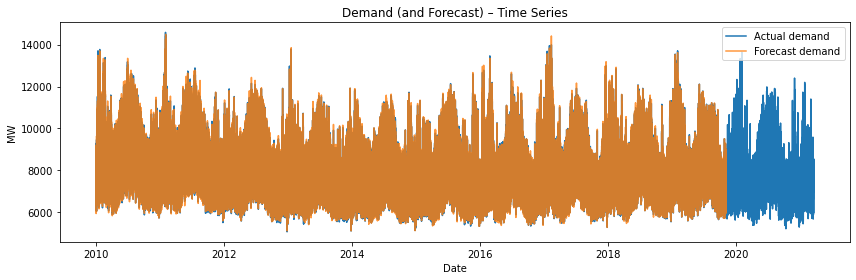

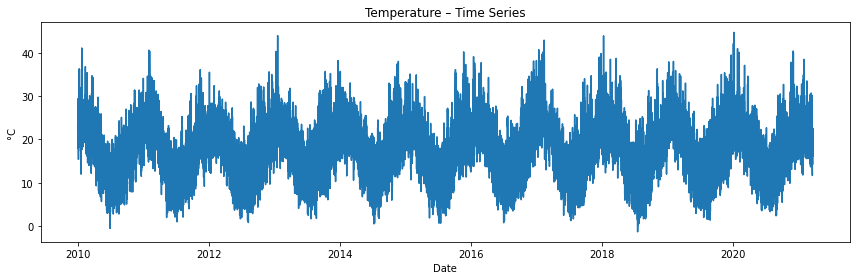

In [8]:
# Demand (+ Forecast)
plt.figure(figsize=(12,4))
plt.plot(df["datetime"], df["demand_mw"], label="Actual demand")
if "forecast_mw" in df.columns:
    plt.plot(df["datetime"], df["forecast_mw"], label="Forecast demand", alpha=0.8)
plt.title("Demand (and Forecast) – Time Series")
plt.xlabel("Date"); plt.ylabel("MW"); plt.legend(); plt.tight_layout()
plt.savefig(OUTDIR / "ts_demand_forecast.png", dpi=160); plt.show()

# Temperature
plt.figure(figsize=(12,4))
plt.plot(df["datetime"], df["temp_c"])
plt.title("Temperature – Time Series")
plt.xlabel("Date"); plt.ylabel("°C"); plt.tight_layout()
plt.savefig(OUTDIR / "ts_temperature.png", dpi=160); plt.show()


### Distributions (histograms)

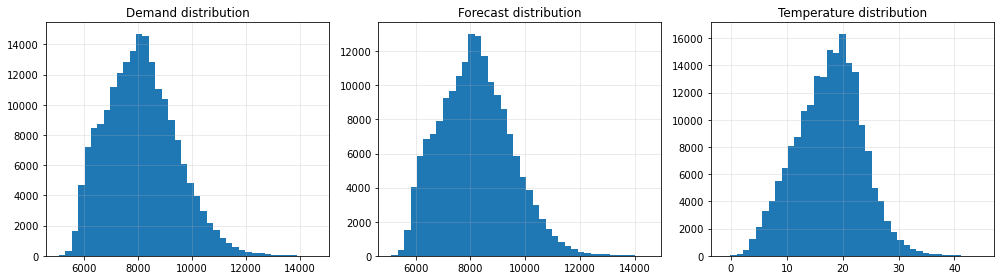

In [9]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].hist(df["demand_mw"].dropna(), bins=40); axes[0].set_title("Demand distribution"); axes[0].grid(True, alpha=0.3)
if "forecast_mw" in df.columns:
    axes[1].hist(df["forecast_mw"].dropna(), bins=40); axes[1].set_title("Forecast distribution"); axes[1].grid(True, alpha=0.3)
else:
    axes[1].axis("off")
axes[2].hist(df["temp_c"].dropna(), bins=40); axes[2].set_title("Temperature distribution"); axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR / "dist_histograms.png", dpi=160); plt.show()


### Scatter: Demand vs Temp, Forecast vs Actual

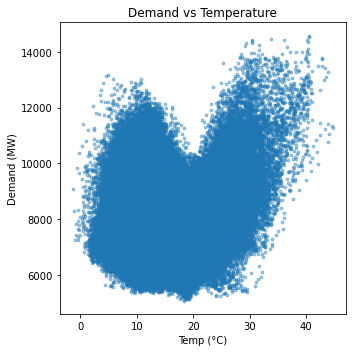

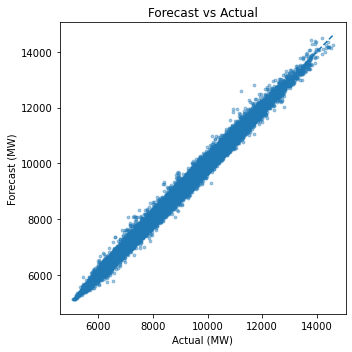

In [10]:
# Demand vs Temp
plt.figure(figsize=(5,5))
plt.scatter(df["temp_c"], df["demand_mw"], s=8, alpha=0.4)
plt.title("Demand vs Temperature"); plt.xlabel("Temp (°C)"); plt.ylabel("Demand (MW)")
plt.tight_layout(); plt.savefig(OUTDIR / "scatter_demand_vs_temp.png", dpi=160); plt.show()

# Forecast vs Actual (if available)
if "forecast_mw" in df.columns:
    plt.figure(figsize=(5,5))
    plt.scatter(df["demand_mw"], df["forecast_mw"], s=8, alpha=0.4)
    lo = float(np.nanmin(df[["demand_mw","forecast_mw"]].values))
    hi = float(np.nanmax(df[["demand_mw","forecast_mw"]].values))
    plt.plot([lo,hi],[lo,hi], linestyle="--")
    plt.title("Forecast vs Actual"); plt.xlabel("Actual (MW)"); plt.ylabel("Forecast (MW)")
    plt.tight_layout(); plt.savefig(OUTDIR / "scatter_forecast_vs_actual.png", dpi=160); plt.show()


### Forecast error diagnostics (if forecast available)

Forecast metrics → MAE: 63.6 MW | RMSE: 87.7 MW | MAPE: 0.77%


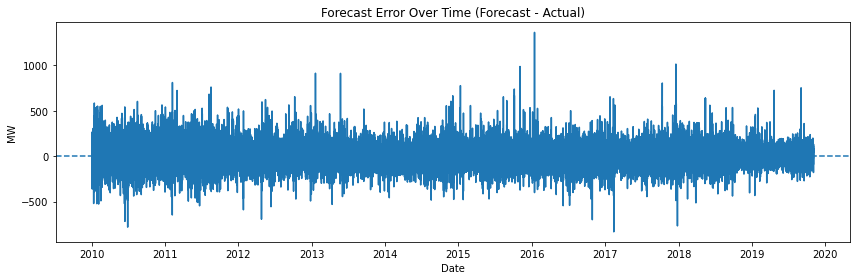

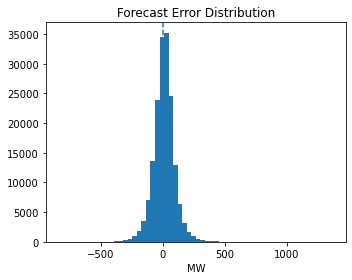

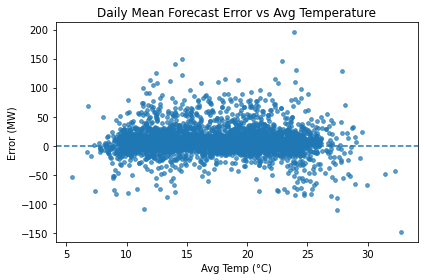

In [11]:
if "forecast_mw" in df.columns:
    # Summary metrics
    mae  = float(df["fcst_abs_error"].mean())
    rmse = float(np.sqrt(np.nanmean(df["fcst_error"]**2)))
    mape = float(np.nanmean(df["fcst_ape"]))
    print(f"Forecast metrics → MAE: {mae:,.1f} MW | RMSE: {rmse:,.1f} MW | MAPE: {mape:,.2f}%")

    # Error time series
    plt.figure(figsize=(12,4))
    plt.plot(df["datetime"], df["fcst_error"]); plt.axhline(0, linestyle="--")
    plt.title("Forecast Error Over Time (Forecast - Actual)")
    plt.xlabel("Date"); plt.ylabel("MW"); plt.tight_layout()
    plt.savefig(OUTDIR / "ts_forecast_error.png", dpi=160); plt.show()

    # Error distribution
    plt.figure(figsize=(5,4))
    plt.hist(df["fcst_error"].dropna(), bins=60); plt.axvline(0, linestyle="--")
    plt.title("Forecast Error Distribution"); plt.xlabel("MW"); plt.tight_layout()
    plt.savefig(OUTDIR / "dist_forecast_error.png", dpi=160); plt.show()

    # Daily mean error vs temperature
    daily = df.set_index("datetime")[["fcst_error","temp_c"]].resample("D").mean().reset_index()
    plt.figure(figsize=(6,4))
    plt.scatter(daily["temp_c"], daily["fcst_error"], s=14, alpha=0.7); plt.axhline(0, linestyle="--")
    plt.title("Daily Mean Forecast Error vs Avg Temperature")
    plt.xlabel("Avg Temp (°C)"); plt.ylabel("Error (MW)"); plt.tight_layout()
    plt.savefig(OUTDIR / "scatter_daily_error_vs_temp.png", dpi=160); plt.show()
else:
    print("No forecast provided → skipping error diagnostics.")


### Daily profiles & correlation heatmap

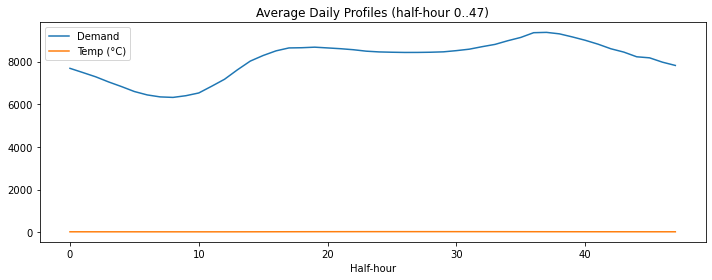

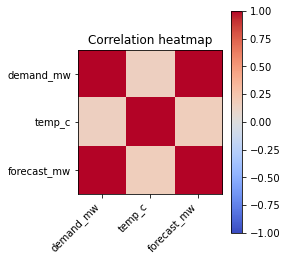

In [12]:
# Average daily profiles (by half-hour)
profile = df.groupby("halfhour", as_index=False)[["demand_mw","temp_c"]].mean()
plt.figure(figsize=(10,4))
plt.plot(profile["halfhour"], profile["demand_mw"], label="Demand")
plt.plot(profile["halfhour"], profile["temp_c"], label="Temp (°C)")
plt.title("Average Daily Profiles (half-hour 0..47)"); plt.xlabel("Half-hour"); plt.legend()
plt.tight_layout(); plt.savefig(OUTDIR / "daily_profiles.png", dpi=160); plt.show()

# Correlation heatmap (matplotlib only)
cols = ["demand_mw","temp_c"] + (["forecast_mw"] if "forecast_mw" in df.columns else [])
C = df[cols].corr()
plt.figure(figsize=(4,4))
plt.imshow(C.values, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title("Correlation heatmap")
plt.tight_layout(); plt.savefig(OUTDIR / "corr_heatmap.png", dpi=160); plt.show()


### Extra EDA: rolling errors & peak-hour focus

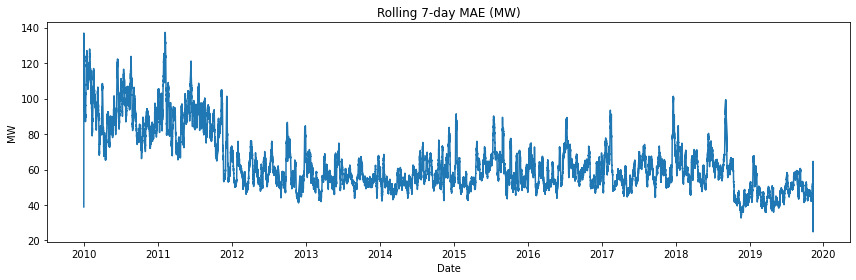

Peak-hour (17–20) → MAE: 75.9 MW | RMSE: 102.1 MW


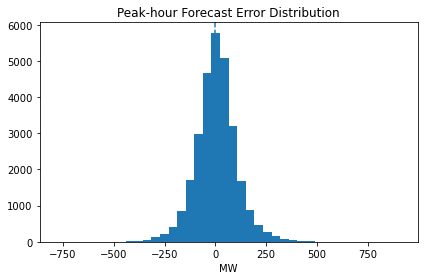

In [13]:
if "forecast_mw" in df.columns:
    # Rolling 7-day MAE (on half-hourly data)
    roll_mae = (df.set_index("datetime")["fcst_abs_error"]
                  .rolling("7D").mean())
    plt.figure(figsize=(12,4))
    plt.plot(roll_mae.index, roll_mae.values)
    plt.title("Rolling 7-day MAE (MW)")
    plt.xlabel("Date"); plt.ylabel("MW")
    plt.tight_layout(); plt.savefig(OUTDIR / "rolling7d_mae.png", dpi=160); plt.show()

    # Peak-hour error (17:00–20:00 local)
    peak = df[(df["hour"]>=17) & (df["hour"]<=20)]
    if not peak.empty:
        p_mae  = float(peak["fcst_abs_error"].mean())
        p_rmse = float(np.sqrt(np.nanmean(peak["fcst_error"]**2)))
        print(f"Peak-hour (17–20) → MAE: {p_mae:,.1f} MW | RMSE: {p_rmse:,.1f} MW")

        plt.figure(figsize=(6,4))
        plt.hist(peak["fcst_error"].dropna(), bins=40); plt.axvline(0, linestyle="--")
        plt.title("Peak-hour Forecast Error Distribution"); plt.xlabel("MW")
        plt.tight_layout(); plt.savefig(OUTDIR / "peak_hour_error_dist.png", dpi=160); plt.show()


### Summary text file

In [14]:
lines = []
lines.append(f"Rows: {len(df):,}")
lines.append(f"Range: {df['datetime'].min()}  ..  {df['datetime'].max()}")
lines.append(f"Nulls → demand={df['demand_mw'].isna().sum():,}, temp={df['temp_c'].isna().sum():,}")
if "forecast_mw" in df.columns:
    mae  = float(df['fcst_abs_error'].mean())
    rmse = float(np.sqrt(np.nanmean(df['fcst_error']**2)))
    mape = float(np.nanmean(df['fcst_ape']))
    lines.append(f"Forecast → MAE={mae:,.1f} MW, RMSE={rmse:,.1f} MW, MAPE={mape:,.2f}%")

(OUTDIR / "_summary.txt").write_text("\n".join(lines), encoding="utf-8")
print("\n".join(lines))
print("\nWrote summary to:", OUTDIR / "_summary.txt")


Rows: 196,513
Range: 2010-01-01 00:00:00  ..  2021-03-18 00:00:00
Nulls → demand=44, temp=299
Forecast → MAE=63.6 MW, RMSE=87.7 MW, MAPE=0.77%

Wrote summary to: /Users/rahellegesse/Documents/rahel_ds_projects/Data/nsw_clean_outputs/_summary.txt
